## Synthetic data for supernovae compilations

#### In this notebook, we add the statistical errors at the covariance matrix $\Sigma$ of the systematic errors of JLA and Pantheon supernovaes compilation.

#### Then, we use the fact that $\Sigma$ is symmetrical and we can to use the spectral theorem: 

$\Sigma = P D P^T$

and we add $D$ to the dataset to train a neural network. 

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers

### Read the JLA covariance matrix

In [2]:
# syscov = np.loadtxt('data/pantheon_errors.txt',skiprows=1).reshape((1048,1048))
syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### This matrix have sigly difference in the out diagonal elements, we fix it:

In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

181

### Now, load the data (redshift, $D_L$ and statistical errors)

In [4]:
# file = 'data/pantheon.txt'
file = 'data/jla_lcparams.txt'
data = pd.read_csv(file, sep = " " ,usecols=['zcmb', 'mb', 'dmb'] )
staterr = data.values[:,2]

### Adding statistical error to the covariance matrix and vizualize it:

In [5]:
covfull = np.copy(syscov)
covfull[np.diag_indices_from(covfull)] += staterr**2
print(np.shape(syscov), np.shape(covfull))
mincov = np.min(covfull)
maxcov = np.max(covfull)
meancov = np.mean(covfull)

(740, 740) (740, 740)


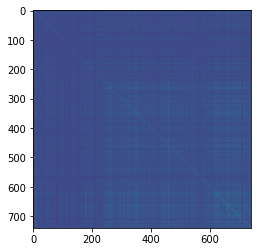

In [6]:
plt.imshow(covfull)

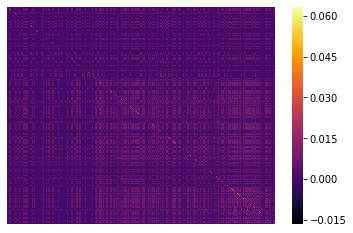

In [7]:
df_covfull = pd.DataFrame(covfull)
sns.heatmap(df_covfull, annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', robust=False)

### Calculate eigenvalues and eigenvectors of the new covariance matrix:

(740,) (740, 740)


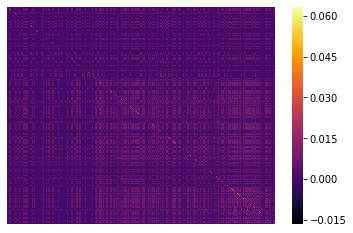

In [8]:
eigenval, eigenvec = sp.linalg.eigh(covfull)
print(np.shape(eigenval), np.shape(eigenvec))
rec_cov = np.matmul(eigenvec, np.diag(eigenval))
rec_cov = np.matmul(rec_cov, np.transpose(eigenvec))
sns.heatmap(pd.DataFrame(rec_cov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', robust=False)


### Verify that there are not complex values:

In [9]:
count = 0

for i in range(len(eigenvec)):
    for j in range(len(eigenvec)):
        if np.iscomplex(eigenvec[i,j]):
            count+=1

print(count)

0


#### Use the QR descomposition to use Q as an Gram-Schmidth orthonormalization and visualize it:

This matrix generate a base for the 740 dimensional space for the JLA data and a base of 1048x1048 for the Pantheon compilation.

In [10]:
ortM, _ = np.array(np.linalg.qr(np.real(eigenvec)))

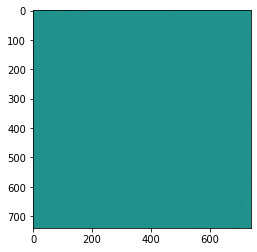

In [11]:
plt.imshow(ortM)

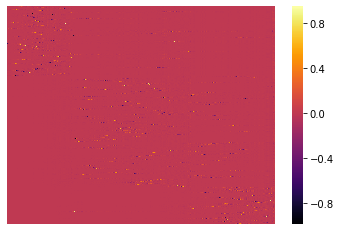

In [12]:
sns.heatmap(pd.DataFrame(ortM), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', robust=False)

### Generation of the data to feed the neural network.

#### We need z, $D_L$ and the eigenvalues

In [13]:
X = data[['zcmb']].values
# scalerx = MinMaxScaler(feature_range=(-1,1))
# scalerx.fit(X.reshape(-1,1))
# X = scalerx.transform(X.reshape(-1,1))
# print(data[['mb']].values)

dl = np.reshape(data[['mb']].values, (len(X), 1))
# scalerdl = MinMaxScaler(feature_range=(-1,1))
# scalerdl.fit(dl.reshape(-1,1))
# dl = scalerdl.transform(dl.reshape(-1,1))

eigenval= np.reshape(eigenval, (len(X), 1))
# scalereig = MinMaxScaler(feature_range=(-1,1))
# scalereig.fit(eigenval.reshape(-1,1))
# eigenval = scalereig.transform(eigenval.reshape(-1,1))

Y = np.concatenate((dl, eigenval), axis=1)
print(np.shape(X), np.shape(Y))




(740, 1) (740, 2)


### Shuffle data and split in test and trainning set

In [14]:
shuffle = [x for x in range(len(X)) if x%2 ==1]
comp = [x for x in range(len(X)) if x%2 ==0]
shuffle.extend(comp)
split = 0.8

X = X[shuffle]
Y = Y[shuffle]

ntrain = int(split * len(X))
indx = [ntrain]
X_train, X_test = np.split(X, indx)
Y_train, Y_test = np.split(Y, indx)

### Define a model and some hyperparameters:

In [15]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0001,
                                   patience=100,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]
# initializer = Constant(value=0.01)
initializer = tf.keras.initializers.RandomNormal() 

def model(input_x):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_x)
    ehidden = Dense(200, activation='relu')(efirst)
    ehidden2 = Dense(150, activation='relu')(ehidden)
    elast = Dense(2, activation='linear')(ehidden2)
    return elast

batch_size = 8
epochs = 500
input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 50)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 302       
Total params: 40,752
Trainable params: 40,752
Non-trainable params: 0
_________________________________________________________________


In [16]:
model_train = neural_model.fit(X_train, Y_train, batch_size=batch_size,
                                    epochs=epochs, verbose=1,
                                    validation_data=(X_test, Y_test),
                                    callbacks=callbacks)

Epoch 1/500
74/74 [==============================] - 0s 5ms/step - loss: 128.9593 - val_loss: 4.1949
Epoch 2/500
74/74 [==============================] - 0s 2ms/step - loss: 7.4790 - val_loss: 3.4443
Epoch 3/500
74/74 [==============================] - 0s 2ms/step - loss: 2.9818 - val_loss: 1.0667
Epoch 4/500
74/74 [==============================] - 0s 3ms/step - loss: 1.2369 - val_loss: 1.2385
Epoch 5/500
74/74 [==============================] - 0s 2ms/step - loss: 0.7676 - val_loss: 1.4351
Epoch 6/500
74/74 [==============================] - 0s 2ms/step - loss: 0.6930 - val_loss: 1.5218
Epoch 7/500
74/74 [==============================] - 0s 3ms/step - loss: 0.6678 - val_loss: 1.5566
Epoch 8/500
74/74 [==============================] - 0s 2ms/step - loss: 0.6904 - val_loss: 1.7030
Epoch 9/500
74/74 [==============================] - 0s 2ms/step - loss: 0.6718 - val_loss: 1.6374
Epoch 10/500
74/74 [==============================] - 0s 3ms/step - loss: 0.6874 - val_loss: 1.8098
Epoch 1

Epoch 83/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0947 - val_loss: 0.1318
Epoch 84/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0818 - val_loss: 0.0974
Epoch 85/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0980
Epoch 86/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0862 - val_loss: 0.0952
Epoch 87/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0835 - val_loss: 0.1265
Epoch 88/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0812 - val_loss: 0.1368
Epoch 89/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0901 - val_loss: 0.0937
Epoch 90/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0885 - val_loss: 0.2007
Epoch 91/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0818 - val_loss: 0.0987
Epoch 92/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0829 - val_loss: 0.0953


74/74 [==============================] - 0s 4ms/step - loss: 0.0713 - val_loss: 0.0829
Epoch 165/500
74/74 [==============================] - 0s 5ms/step - loss: 0.0736 - val_loss: 0.0852
Epoch 166/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0667 - val_loss: 0.0915
Epoch 167/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0756 - val_loss: 0.0890
Epoch 168/500
74/74 [==============================] - 0s 6ms/step - loss: 0.0682 - val_loss: 0.1295
Epoch 169/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0712 - val_loss: 0.0890
Epoch 170/500
74/74 [==============================] - 0s 5ms/step - loss: 0.0806 - val_loss: 0.1136
Epoch 171/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0796 - val_loss: 0.1763
Epoch 172/500
74/74 [==============================] - 0s 4ms/step - loss: 0.1020 - val_loss: 0.0871
Epoch 173/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0715 - val_loss: 0.0855
Epoc

74/74 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0926
Epoch 246/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0762 - val_loss: 0.1034
Epoch 247/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0642 - val_loss: 0.1046
Epoch 248/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0671 - val_loss: 0.0861
Epoch 249/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0647 - val_loss: 0.0861
Epoch 250/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0786 - val_loss: 0.0832
Epoch 251/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0667 - val_loss: 0.0859
Epoch 252/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0674 - val_loss: 0.0964
Epoch 253/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0750 - val_loss: 0.0986
Epoch 254/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0733 - val_loss: 0.1370
Epoc

74/74 [==============================] - 0s 3ms/step - loss: 0.0614 - val_loss: 0.0767
Epoch 327/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0635 - val_loss: 0.1055
Epoch 328/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0635 - val_loss: 0.0697
Epoch 329/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0884
Epoch 330/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0734 - val_loss: 0.2146
Epoch 331/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0642 - val_loss: 0.0703
Epoch 332/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0653 - val_loss: 0.1480
Epoch 333/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0654 - val_loss: 0.0716
Epoch 334/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0604 - val_loss: 0.0717
Epoch 335/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0627 - val_loss: 0.0736
Epoc

74/74 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0927
Epoch 408/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0653 - val_loss: 0.0881
Epoch 409/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0623 - val_loss: 0.0873
Epoch 410/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0781
Epoch 411/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0600
Epoch 412/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0557 - val_loss: 0.0613
Epoch 413/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0707 - val_loss: 0.0737
Epoch 414/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0632 - val_loss: 0.0582
Epoch 415/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.1031
Epoch 416/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0634
Epoc

74/74 [==============================] - 0s 2ms/step - loss: 0.0603 - val_loss: 0.0590
Epoch 489/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0615 - val_loss: 0.0571
Epoch 490/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0574 - val_loss: 0.0574
Epoch 491/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0557 - val_loss: 0.0727
Epoch 492/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0524
Epoch 493/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0504
Epoch 494/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0568
Epoch 495/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0514
Epoch 496/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0761
Epoch 497/500
74/74 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0573
Epoc

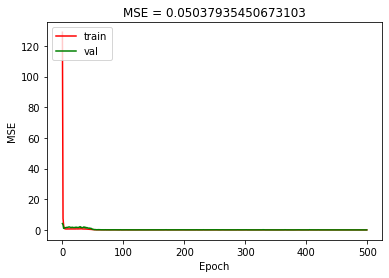

In [17]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('MSE = {}'.format(np.min(model_train.history['val_loss'])))
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_hz.png", dpi=200)

In [18]:
ranz = np.random.uniform(0, 2, size=100)
pred_random = neural_model.predict(ranz)
# pred_random
np.shape(pred_random[:, 1])

(100,)

### Now we can construct a covariance matrix of lower dimension generating the eigenvalues for the new subspace and using a cutted matrix from the eigenvector orthonormalized matrix that this should be a base of the subspace.

In [19]:
new_D = np.diag(pred_random[:, 1])
print(np.shape(new_D))
subspaceDim = len(new_D)
reduce_eigenvec = ortM[:subspaceDim, :subspaceDim]
print(subspaceDim)
trans_eigenvec = np.transpose(reduce_eigenvec)
new_cov = np.matmul(reduce_eigenvec, new_D)
new_cov = np.matmul(new_cov, trans_eigenvec)

(100, 100)
100


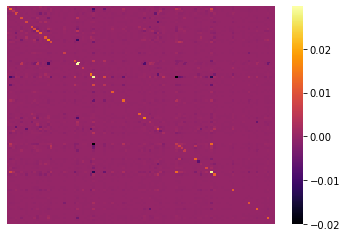

In [20]:
sns.heatmap(pd.DataFrame(new_cov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', robust=False, cbar=True)

In [21]:
new_cov

array([[ 6.17017520e-03, -5.19109891e-04, -1.51410971e-04, ...,
        -1.19893052e-04, -1.04294633e-04, -1.54452228e-05],
       [-5.19109891e-04,  1.30622386e-02,  1.01693151e-03, ...,
        -2.80601711e-04,  5.51012147e-05, -9.97356511e-07],
       [-1.51410971e-04,  1.01693151e-03,  4.24602727e-03, ...,
        -1.71144251e-04,  5.88941053e-05,  9.22814743e-06],
       ...,
       [-1.19893052e-04, -2.80601711e-04, -1.71144251e-04, ...,
         1.20678556e-02,  2.36563073e-05, -4.05983634e-05],
       [-1.04294633e-04,  5.51012147e-05,  5.88941053e-05, ...,
         2.36563073e-05,  4.89687859e-05, -4.96161175e-06],
       [-1.54452228e-05, -9.97356511e-07,  9.22814743e-06, ...,
        -4.05983634e-05, -4.96161175e-06,  1.12333720e-05]])